In [70]:
# this assumes torque at the rotation

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pydrake.math import sin, cos
import time

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [3]:
# using meschat as the visualizer
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [4]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [5]:
# define dynamical properties of the system
mass = 1.0
length = 1.0
gravity = 9.81
water_distance = .9 # distance from the top of the pendulum to the water
damping_coeff = 0.0
water_coeff = 2.0

water_thresh = 0.001 # region around touching the water at which to zero velocity

can_hit_again = True # this must be false immediately after a hit and then true after reversing direction
direction_of_hit = 0.0

In [6]:
# create the objects
pivot = vis["pivot"]
pole = pivot["pole"]
water = vis["water"]

# draw the objects
pivot.set_object(g.Sphere(radius=.1)) # set pivot to be a sphere
pole.set_object(g.Cylinder(height=1.0,radius=.05)) # create cylinder to pivot

# position the objects
pole.set_transform(tf.translation_matrix([0,length/2.0,0])) # set location of pole
pivot.set_transform(tf.rotation_matrix(-np.pi/2.0,[1,0,0])) # rotate the pole

# position the water
water.set_object(g.Box([2,2,.01]))
water.set_transform(tf.translation_matrix([0,0,-water_distance]))

In [7]:
# states
theta = 0.0 # theta
theta_dot = 0.0 # theta derivative

state_initial = [theta, theta_dot] # initial state vector
def draw_transformation(state):
    pivot.set_transform(tf.rotation_matrix(state[0]-np.pi/2.0,[1,0,0])) # rotate the pole
draw_transformation(state_initial) # draw the initial state

In [8]:
# check if the pendulum is contact with water
def contact_check(state):
    global length, water_distance
    theta = state[0]
    
    # check if theta is in the water region
    if length*cos(theta) > water_distance:
        return True
    else:
        return False

In [9]:
# dyanmics with damping
def pend_contact(state, u):
    
    # include necessary parameters
    global mass, length, gravity, water_coeff, damping_coeff
    
    # unpack values
    theta = state[0]
    theta_dot = state[1]
    
    # set the derivative values
    derivs = np.zeros_like(state)
    derivs[0] = theta_dot # set theta_dot to theta_dot
    # dynamics of damped pendulum
    derivs[1] = -water_coeff*theta_dot/(mass*length**2) + u[0]/(mass*length**2) - gravity*sin(theta)/length
    
    return derivs

In [10]:
def pend_no_contact(state, u):
    
    # include necessary parameters
    global mass, length, gravity, water_coeff, damping_coeff
    
    # unpack values
    theta = state[0]
    theta_dot = state[1]
    
    # set the derivative values
    derivs = np.zeros_like(state)
    derivs[0] = theta_dot # set theta_dot to theta_dot
    # dynamics of damped pendulum
    derivs[1] = -damping_coeff*theta_dot/(mass*length**2) + u[0]/(mass*length**2) - gravity*sin(theta)/length
    
    return derivs

In [11]:
# define the transition between states and checks for collision
def pend_guard(state):
    global length, water_distance, water_thresh, can_hit_again, direction_of_hit
    theta = state[0]
    theta_dot = state[1]
    
    distance_dot = -length*sin(theta)*theta_dot
    distance = length*cos(theta) - water_distance
    
    close_enough = distance > -water_thresh and distance < water_thresh
    
    guard_state = np.zeros_like(state)
    guard_state[0] = state[0] # theta
    guard_state[1] = state[1] # theta_dot
    
    # check if we can hit again
    if distance_dot * direction_of_hit < 0:
        can_hit_again = True
    
    # moving down
    # close enough to ground
    # didn't just hit
#     print(can_hit_again)
    if distance_dot > 0 and close_enough and can_hit_again:
        guard_state[1] = 0.0 # zero out the velocity
#         print("Zeroed Velocity: {}".format(guard_state))
        can_hit_again = False
        direction_of_hit = distance_dot
        return guard_state
        
    return guard_state

In [12]:
# get the dynamics
def pend_dynamics(state, u):
#     guard_state = pend_guard(state)
    guard_state = state
    if contact_check(guard_state):
        return pend_contact(guard_state,u)
    else:
        return pend_no_contact(guard_state,u)

In [13]:
def compute_optimal_control(initial_state, final_state, min_time, max_time, max_torque):
    # Setup solver
    mp = MathematicalProgram()

    # number knot points
    N = 100
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
    # Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time

    # State decision variabless
    x = mp.NewContinuousVariables(2, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(2, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
    # State Constraints
    error_thresh = 0.0001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + pend_dynamics(total_x[n,:], total_u[n,:])*dt
  
        # Make sure the actual and predicted align to follow dynamics
        for j in range(2):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)

    # Quadratic Cost in control effort
    # cost of u
#     mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial and final state constraints
    for i in range(2):
        # initial
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)
    
        # final
        final_state_error = x_over_time[-1,i] - final_state[i]
        mp.AddConstraint(final_state_error <= error_thresh)
        mp.AddConstraint(final_state_error >= -error_thresh)
    
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
#     mp.AddConstraint(time_used[0] <= maximum_time)

    # add torque constraints
    for n in range(N):
        mp.AddConstraint(u_over_time[n,0] <= max_torque)
        mp.AddConstraint(u_over_time[n,0] >= -max_torque)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    return trajectory, input_trajectory, time_array

In [14]:
# Different starting places
origin = (0.0,0.0) # theta, theta_dot

# Set the desired final conditions
swing_up = (np.pi,0.0)

# Set the time constraints
minimum_time = 2.0; maximum_time = 20.

max_torque = 5.0

# Solve the trajectory optimization
traj, input_traj, time_array = compute_optimal_control(origin, swing_up, minimum_time, maximum_time, max_torque)


Number of decision vars 303
SolutionResult.kSolutionFound


In [15]:
# Print trajectory information
print "Trajectory size: ", traj.shape
print "Input size: ", input_traj.shape
print "\n"

# Print initial conditions
print "Initial state: ", traj[0]
print "\n"

# Print final conditionsa
print "Final state: ", traj[-1]

print "Final time: ", time_array[-1]
print "Total energ: ", input_traj.dot(input_traj)

Trajectory size:  (101, 2)
Input size:  (100,)


Initial state:  [0. 0.]


Final state:  [3.14149265e+00 1.00000000e-04]
Final time:  20.981174995061732
Total energ:  2260.0198131946236


In [16]:
def plot_theta(trajectory, time_array):
    theta = trajectory[:,0]
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(time_array, theta)
    plt.show()
    
def plot_u(input_trajectory, time_array):
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(time_array[:-1], input_trajectory)
    plt.show()

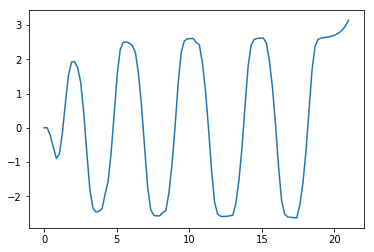

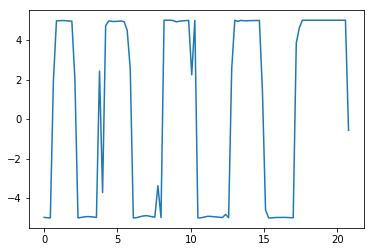

In [17]:
# Plot
plot_theta(traj, time_array)
plot_u(input_traj, time_array)

In [18]:
# trajectory found
dt = time_array[1] - time_array[0]
for i in range(len(traj)):
    draw_transformation(traj[i,:])
    time.sleep(dt)

In [19]:
can_hit_again = True
current_state = [2.0, 0.0]
draw_transformation(current_state)

In [20]:
# code to simulate passive dynamics
sec = 5.0 # seconds
steps_per_sec = 1000.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step
for t in np.linspace(0,sec,int(num_steps)):
    current_state = current_state + pend_dynamics(current_state,[0.0])*sec_per_step
    draw_transformation(current_state)
    time.sleep(sec_per_step)

In [753]:
# simulate the control with integration found
dt = time_array[1] - time_array[0]
current_state = traj[0,:] # set the initial state
for index, t in enumerate(time_array[:-1]):
    draw_transformation(current_state)
    torque = input_traj[index]
    current_state = current_state + pend_dynamics(current_state,[torque])*dt
    time.sleep(dt)
draw_transformation(current_state)

In [21]:
num_q_bins = 30 # num discrete thetas
num_qdot_bins = 50 # num distrete theta_dots

q_bins = np.linspace(-np.pi,np.pi,num_q_bins)
qdot_bins = np.linspace(-3.0, 3.0, num_qdot_bins)

state_grid = [q_bins, qdot_bins]

In [22]:
input_limit = 5.0
input_bins = 9
input_grid = [np.linspace(-input_limit, input_limit, input_bins)]

In [23]:
[Q, Qdot] = np.meshgrid(q_bins, qdot_bins)

In [24]:
max_iterations = 10000
J_iterations  = np.zeros((num_qdot_bins, num_q_bins, max_iterations))
Pi_iterations = np.zeros((num_qdot_bins, num_q_bins, max_iterations))

In [43]:
# create cost function
# penalizes being away from origin and torque inputs
# cost on the state
# def pend_cost(state):
#     x = np.asarray(state)
#     u_np = np.asarray(u)
#     return x.dot(x) + 5*u_np.dot(u_np)

def pend_cost(state):
    x = np.asarray(state)
    return x.dot(x)

In [42]:
# return the index for the correct state
def get_closest_state(state,q_bins,qdot_bins):
    # returns [q_index, qdot_index]
    theta = state[0]
    thetadot = state[1]
    
    theta_divisor = (q_bins[-1] - q_bins[0])/len(q_bins)
    q_index = np.int((theta - q_bins[0])/theta_divisor)
    
    thetadot_divisor = (qdot_bins[-1] - qdot_bins[0])/len(qdot_bins)
    qdot_index = np.int((thetadot - qdot_bins[0])/thetadot_divisor)
    
    return [q_index, qdot_index]

In [33]:
# run the algorithm
count = 0
gamma = 1.0
num_iterations = 100

for i in range(num_iterations - 1):
    for q_index, theta in enumerate(state_grid[0]):
        for qdot_index, theta_dot in enumerate(state_grid[1]):
            state = [theta,theta_dot]

            best_cost = None
            best_action = None
            # find the best action from this state
            current_cost = J_iterations[qdot_index,q_index,0]
            for a_index, a in enumerate(input_grid[0]):
                next_state = state + pend_dynamics(state, [a])*dt
                next_qbin, next_qdotbin = get_closest_state(next_state, q_bins, qdot_bins)
                actual_state = [state_grid[0][next_qbin], state_grid[1][next_qdotbin]]
                cost = pend_cost(actual_state)
                if cost < best_cost or best_cost is None:
                    best_cost = cost
                    best_action = a

            # now we have the best action for that state
            J_iterations[qdot_index,q_index,0] = best_cost
            Pi_iterations[qdot_index,q_index,0] = best_action

<IPython.core.display.Javascript object>


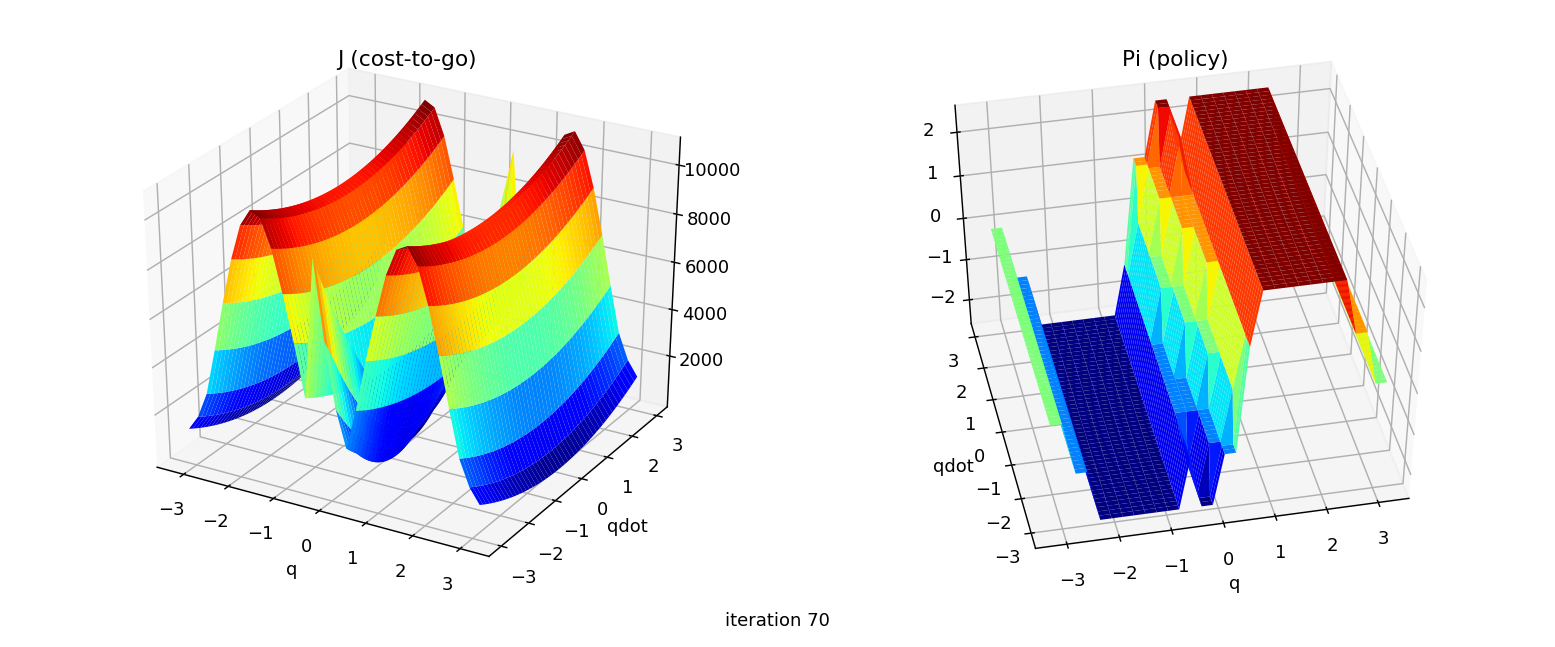

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax.axis('off')
ax2.axis('off')

ax = fig.add_subplot(121, projection='3d')
ax.set_title('J (cost-to-go)')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Pi (policy)')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")
plt.tight_layout()

J_initial = J_iterations[:,:,0]
J_surface = [ax.plot_surface(Q, Qdot, J_initial, rstride=1, cstride=1,
                       cmap=cm.jet)]

Pi_initial = Pi_iterations[:,:,0]
Pi_surface = [ax2.plot_surface(Q, Qdot, Pi_initial, rstride=1, cstride=1,
                        cmap=cm.jet)]

def update_plots(iteration, J_iterations, J_surface, Pi_iterations, Pi_surface):
    if iteration % 10 != 0:
        return # only plot every 10th
    J_surface[0].remove()
    J_surface[0] = ax.plot_surface(Q, Qdot, J_iterations[:,:,iteration], rstride=1, cstride=1,
                        cmap=cm.jet)

    for txt in fig.texts:
        txt.set_visible(False)
    fig.text(0.5, 0.04, 'iteration '+str(iteration), ha='center', va='center')
    
    Pi_surface[0].remove()
    Pi_surface[0] = ax2.plot_surface(Q, Qdot, Pi_iterations[:,:,iteration], rstride=1, cstride=1,
                        cmap=cm.jet)
    

animate = animation.FuncAnimation(fig, update_plots, num_iterations, interval=1, fargs=(J_iterations, J_surface, 
                                                                            Pi_iterations, Pi_surface))